## March Madness Logistic Regression

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from math import sin, cos, sqrt, atan2, radians
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,
                             f1_score, log_loss, roc_curve, confusion_matrix, precision_score, recall_score)
import statsmodels.formula.api as smf

In [2]:
def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [3]:
mm_data = pd.read_csv('NCAA_Tourney_2002_2021.csv').query("season<2021").reset_index(drop=True)

In [4]:
mm_data['dist1'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
mm_data['dist2'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)

In [5]:
mm_data['diff_dist'] = mm_data['dist1'] - mm_data['dist2']

## Pythag College Basketball
E(W%) = points scored^11.5 / (points scored^11.5+points allowed^11.5)

In [6]:
mm_data['exp_win1'] = (mm_data['team1_adjoe']**11.5)/ ((mm_data['team1_adjde']**11.5)+(mm_data['team1_adjoe']**11.5))
mm_data['exp_win2'] = (mm_data['team2_adjoe']**11.5)/ ((mm_data['team2_adjde']**11.5)+(mm_data['team2_adjoe']**11.5))

## Log Odds
P(W) = (A - A * B) / (A + B - 2*A*B)

In [7]:
mm_data['team1_log5'] = (mm_data['exp_win1'] - (mm_data['exp_win1']*mm_data['exp_win2']))/ (mm_data['exp_win1']+mm_data['exp_win2']-(2*mm_data['exp_win1']*mm_data['exp_win2']))

In [8]:
mm_data[['team1_adjoe','team1_teamname','season','team2_teamname','team1_adjde','exp_win1','exp_win2','team1_log5']].head()

,team1_adjoe,team1_teamname,season,team2_teamname,team1_adjde,exp_win1,exp_win2,team1_log5
0,106.296,F Dickinson,2019,Prairie View,110.5500,0.389061,0.382990,0.506403
1,114.952,Belmont,2019,Temple,101.8860,0.800207,0.738939,0.585922
2,106.675,N Dakota St,2019,NC Central,109.8730,0.415885,0.208404,0.730051
3,109.886,Arizona St,2019,St John's,98.6844,0.774944,0.721882,0.570190
4,110.803,Minnesota,2019,Louisville,96.3335,0.833312,0.913200,0.322116


## Seed Diff

In [9]:
mm_data['seed_diff'] = mm_data['team1_seed'] - mm_data['team2_seed']

In [10]:
mm_data[['game_id','exp_win1','exp_win2','team2_score','team1_score','diff_dist','team1_log5','team1_id','team2_id']].head()

,game_id,exp_win1,exp_win2,team2_score,team1_score,diff_dist,team1_log5,team1_id,team2_id
0,2019-1192-1341,0.389061,0.382990,76,82,-648.033425,0.506403,1192,1341
1,2019-1125-1396,0.800207,0.738939,70,81,-307.876634,0.585922,1125,1396
2,2019-1295-1300,0.415885,0.208404,74,78,663.316546,0.730051,1295,1300
3,2019-1113-1385,0.774944,0.721882,65,74,1676.167033,0.570190,1113,1385
4,2019-1278-1257,0.833312,0.913200,76,86,-391.001293,0.322116,1278,1257


## Split Data

In [11]:
mm_data.dropna(subset=['team1_log5'], inplace=True)

In [12]:
mm_data['team1_win'] = (mm_data['team1_score']>mm_data['team2_score']).astype(int)

In [13]:
training_columns = ['game_id','season','team1_win','exp_win1','exp_win2','team2_score',
                                    'team1_score','diff_dist','team1_log5','team1_id','team2_id','seed_diff']
mm_data_1 = mm_data.sample(frac=.5, random_state=15)[training_columns]
mm_data_2 = mm_data[~mm_data.index.isin(mm_data_1.index)][training_columns].reset_index(drop=True)
mm_data_1 = mm_data_1.reset_index(drop=True)

In [14]:
mm_data_2['team1_win'] = 0
mm_data_2['diff_dist'] = mm_data_2['diff_dist']*-1
mm_data_2['team1_log5'] = 1-mm_data_2['team1_log5']
mm_data_2['game_id'] = (mm_data_2['game_id'].str.split('-', expand=True)[0] 
                           + '-' + mm_data_2['game_id'].str.split('-', expand=True)[2] 
                           + '-' + mm_data_2['game_id'].str.split('-', expand=True)[1]
                           ) 
mm_data_2['seed_diff'] = mm_data_2['seed_diff']*-1
mm_data_2.columns = ['game_id', 'season', 'team1_win', 'exp_win2', 'exp_win1', 'team1_score', 'team2_score', 'diff_dist', 'team1_log5',
 'team2_id', 'team1_id','seed_diff']

In [15]:
mm_train = pd.concat([mm_data_2, mm_data_1]).reset_index(drop=True)

In [16]:
train, test = train_test_split(mm_train, train_size=.7)

In [17]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [18]:
train

,game_id,season,team1_win,exp_win2,exp_win1,team1_score,team2_score,diff_dist,team1_log5,team2_id,team1_id,seed_diff
0,2010-1288-1452,2010,0,0.927175,0.539393,50,77,63.861646,0.084232,1452,1288,13
1,2007-1207-1130,2007,1,0.805249,0.946010,62,55,-624.958332,0.809077,1130,1207,-5
2,2012-1458-1393,2012,0,0.931150,0.909229,63,64,1076.745438,0.425503,1393,1458,3
3,2006-1301-1400,2006,0,0.923374,0.821614,54,75,1405.093213,0.276521,1400,1301,8
4,2004-1242-1412,2004,1,0.820315,0.860914,100,74,-207.109959,0.575522,1412,1242,-5
...,...,...,...,...,...,...,...,...,...,...,...,...
820,2011-1246-1452,2011,1,0.879452,0.926438,71,63,-183.064718,0.633201,1452,1246,-1
821,2002-1130-1400,2002,0,0.822470,0.740474,57,70,2193.143508,0.381134,1400,1130,5
822,2011-1364-1196,2011,0,0.882301,0.594926,51,79,3421.739621,0.163826,1196,1364,13
823,2010-1124-1388,2010,1,0.863781,0.914825,72,49,-51.082662,0.628777,1388,1124,-7


## Initial Check

In [19]:
train.groupby('team1_win')['team1_log5'].mean()

team1_win
0    0.362732
1    0.609903
Name: team1_log5, dtype: float64

In [20]:
train.groupby('team1_win')['seed_diff'].mean()

team1_win
0    4.096059
1   -3.374702
Name: seed_diff, dtype: float64

In [21]:
train.groupby('team1_win')['diff_dist'].mean()

team1_win
0    219.972630
1   -197.935978
Name: diff_dist, dtype: float64

## Train Logit

In [22]:
logit = LogisticRegression()
logit.fit(X=train[['seed_diff']], y=train['team1_win'])

LogisticRegression()

In [23]:
seed_smlogit = smf.logit("team1_win ~ seed_diff", train).fit()
seed_smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.553115
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                  825
Model:                          Logit   Df Residuals:                      823
Method:                           MLE   Df Model:                            1
Date:                Tue, 30 Nov 2021   Pseudo R-squ.:                  0.2019
Time:                        16:48:13   Log-Likelihood:                -456.32
converged:                       True   LL-Null:                       -571.74
Covariance Type:            nonrobust   LLR p-value:                 3.893e-52
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0964      0.081      1.193      0.233      -0.062       0.255
seed_diff     -0.1704      0.013    -12.741      0.000      -0.197      -0.144
==============================================================================
"""

In [24]:
test['prob'] = logit.predict_proba(test[['seed_diff']])[:,1]
test['prediction'] = logit.predict(test[['seed_diff']])

In [25]:
test[['game_id','seed_diff','team1_win','prob','prediction']].head()

,game_id,seed_diff,team1_win,prob,prediction
0,2004-1356-1104,1,0,0.481507,0
1,2016-1181-1463,-8,1,0.811404,1
2,2016-1143-1218,-9,0,0.836102,1
3,2002-1221-1242,15,0,0.078789,0
4,2006-1417-1104,-8,1,0.811404,1


In [26]:
test.groupby('team1_win')['prob'].mean()

team1_win
0    0.370524
1    0.612574
Name: prob, dtype: float64

<AxesSubplot:xlabel='prob', ylabel='team1_log5'>

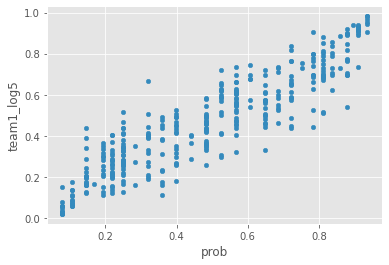

In [27]:
test.plot(kind='scatter', x='prob',y='team1_log5')

In [28]:
confusion_matrix(test['team1_win'], test['prediction'])

array([[132,  51],
       [ 53, 118]])

In [29]:
accuracy_score(test['team1_win'], test['prediction'],)

0.7062146892655368

In [30]:
precision_score(test['team1_win'], test['prediction'])

0.6982248520710059

In [31]:
recall_score(test['team1_win'], test['prediction'])

0.6900584795321637

In [32]:
f1_score(test['team1_win'], test['prediction'])

0.6941176470588235

In [33]:
log_loss(test['team1_win'].values, test['prob'].values, labels=[0,1])

0.5669387470641177

In [34]:
def plot_roc(fpr, tpr, roc_auc):
    """Plots the ROC curve for the win probability model along with
    the AUC.
    """
    fig, ax = plt.subplots()
    ax.set(title='Receiver Operating Characteristic',
           xlim=[0, 1], ylim=[0, 1], xlabel='False Positive Rate',
           ylabel='True Positive Rate')
    ax.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='lower right')

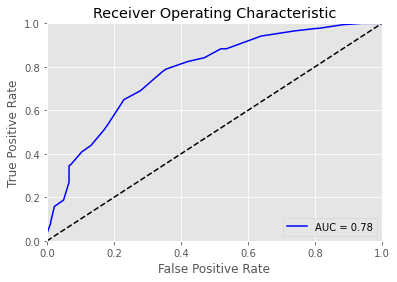

In [35]:
fpr, tpr, thresholds = roc_curve(test['team1_win'].values, test['prob'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [36]:
roc_auc_score(test['team1_win'].values, test['prob'].values)

0.7771067011791774

## Add Seed Difference & Distance

In [37]:
logit = LogisticRegression()
logit.fit(train[['team1_log5','diff_dist','seed_diff']], train['team1_win'])

LogisticRegression()

In [38]:
smlogit = smf.logit("team1_win ~ team1_log5 + diff_dist + seed_diff", train).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.534977
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                  825
Model:                          Logit   Df Residuals:                      821
Method:                           MLE   Df Model:                            3
Date:                Tue, 30 Nov 2021   Pseudo R-squ.:                  0.2281
Time:                        16:48:19   Log-Likelihood:                -441.36
converged:                       True   LL-Null:                       -571.74
Covariance Type:            nonrobust   LLR p-value:                 3.055e-56
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9485      0.404     -4.818      0.000      -2.741      -1.156
team1_log5     4.1196      0.800      5.152      0.000       2.552       5.687
diff_dist  -8.187e-05   6.98e-05     -1.173      0.241      -0.000    5.49e-05
seed_diff     -0.0553      0.025     -2.221      0.026      -0.104      -0.006
==============================================================================
"""

In [39]:
test['prob'] = logit.predict_proba(test[['team1_log5','diff_dist','seed_diff']])[:,1]
test['prediction'] = logit.predict(test[['team1_log5','diff_dist','seed_diff']])

In [40]:
accuracy_score(test['team1_win'], test['prediction'],)

0.7175141242937854

In [41]:
precision_score(test['team1_win'], test['prediction'])

0.7125748502994012

In [42]:
recall_score(test['team1_win'], test['prediction'])

0.695906432748538

In [43]:
f1_score(test['team1_win'], test['prediction'])

0.7041420118343196

In [44]:
log_loss(test['team1_win'].values, test['prob'].values)

0.551461857482174

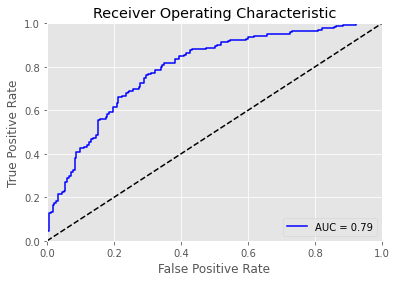

In [45]:
fpr, tpr, thresholds = roc_curve(test['team1_win'].values, test['prob'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [46]:
roc_auc_score(test['team1_win'].values, test['prob'].values)

0.7927971111750232

## Create Example Submission

In [47]:
example_submission = pd.read_csv('NCAA_Tourney_2002_2021.csv').query("season==2021").reset_index(drop=True)

In [48]:
example_submission['seed_diff'] = example_submission['team1_seed'] - example_submission['team2_seed']

In [49]:
example_submission['prob'] = seed_smlogit.predict(example_submission['seed_diff'])

In [50]:
example_submission[['game_id','prob']].head()

,game_id,prob
0,2021-1211-1425,0.720766
1,2021-1211-1166,0.685224
2,2021-1425-1332,0.566292
3,2021-1211-1328,0.783983
4,2021-1332-1234,0.319613


In [51]:
example_submission[['game_id','prob']].shape

(67, 2)

In [52]:
example_submission[['game_id','prob']].to_csv("trp_example_submission.csv", index=False)